In [42]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [43]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:0' id GPU
n_epochs = 10
batch_size = 128

In [44]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)

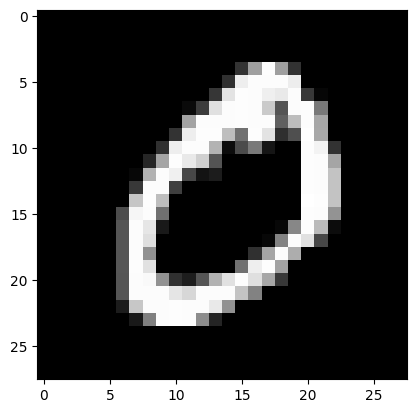

In [45]:
plt.imshow(dataset_train.data[1].detach().numpy(), cmap='gray')
plt.show()

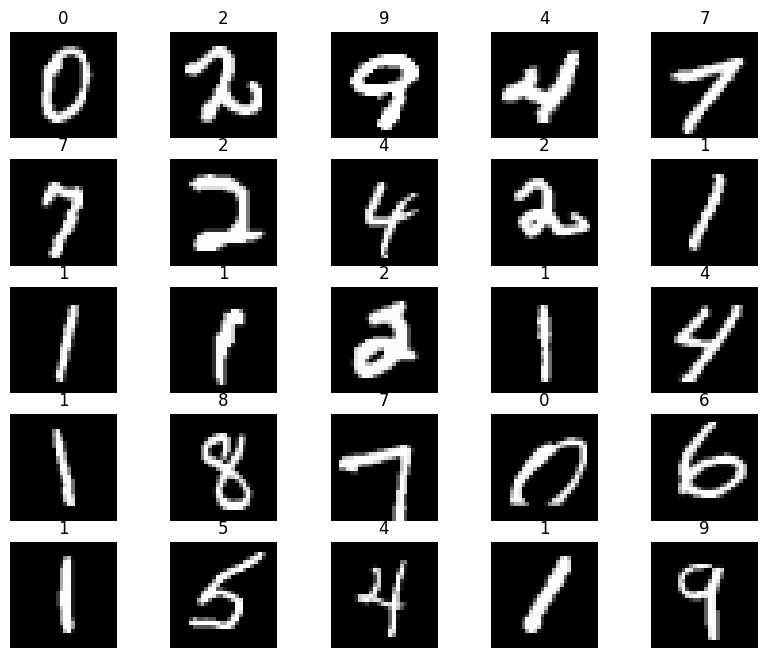

In [46]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
 sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
 img, label = dataset_train[sample_idx]
 figure.add_subplot(rows, cols, i)
 plt.title(label)
 plt.axis("off")
 plt.imshow(img.squeeze(), cmap="gray")
plt.show()

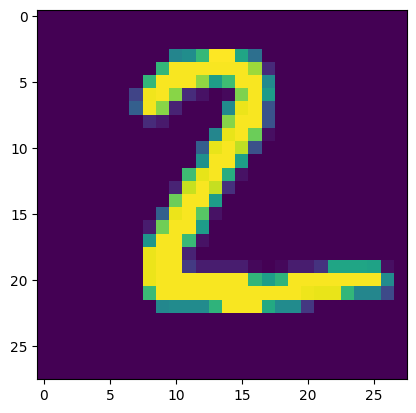

In [47]:
plt.imshow(dataset_test.data[1].detach().numpy())
plt.show()

In [48]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom init nn.init.xavier_uniform(self.linear1.weight) 
        self.do = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ(x)
        x = self.do(x)
        x = self.linear2(x)

        return x

In [49]:
dataset_train = datasets.MNIST('.', train=True, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

In [50]:
dataloader_train = DataLoader(dataset_train, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True
                        )

In [51]:
dataset_test = datasets.MNIST('.', train=False, download=True)

In [52]:
dataloader_test = DataLoader(dataset_test, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )

In [53]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [54]:
for epoch in range(n_epochs):
    # train model
    model.train()
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()
        batch['target'] = batch['target'].type(torch.LongTensor)
        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    # test model
    model.eval()
    for i, batch in enumerate(dataloader_test):
              batch['target'] = batch['target'].type(torch.LongTensor)
              inputs, labels = batch
              loss_test = 0
              with torch.no_grad():
                  predict = model(batch['data'].to(device))
                  loss_test += loss_func(predict, batch['target'].to(device))
    print('test loss:', (loss_test / i).item())
    
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.317725658416748
epoch: 0, step: 200, loss: 0.3282809555530548
epoch: 0, step: 400, loss: 0.21401742100715637
test loss: 0.0030144734773784876
epoch: 1, step: 0, loss: 0.26562750339508057
epoch: 1, step: 200, loss: 0.19594794511795044
epoch: 1, step: 400, loss: 0.16106215119361877
test loss: 0.0019336733967065811
epoch: 2, step: 0, loss: 0.09371186047792435
epoch: 2, step: 200, loss: 0.07811082154512405
epoch: 2, step: 400, loss: 0.0652960017323494
test loss: 0.0014810471329838037
epoch: 3, step: 0, loss: 0.0430290624499321
epoch: 3, step: 200, loss: 0.16651442646980286
epoch: 3, step: 400, loss: 0.01855512522161007
test loss: 0.0007761784363538027
epoch: 4, step: 0, loss: 0.06536523997783661
epoch: 4, step: 200, loss: 0.10260087251663208
epoch: 4, step: 400, loss: 0.1081906259059906
test loss: 0.00018515046394895762
epoch: 5, step: 0, loss: 0.017992286011576653
epoch: 5, step: 200, loss: 0.017904525622725487
epoch: 5, step: 400, loss: 0.08293063938617706
test

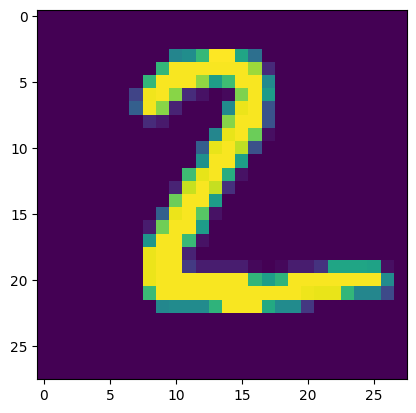

predict: 2
true:    2


In [55]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).view(1, -1).to(device).float()
target = dataset_test.targets[i].tolist()
model.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model(data)).squeeze().detach()
print(f"predict: {predict}")
print(f"true:    {target}")

In [56]:
class LinearModel1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.do = nn.Dropout(dropout_p)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, X):
        X = self.act(self.do(self.linear1(X)))
        X = self.act(self.do(self.linear2(X)))
        X = self.linear3(X)

        return X

In [57]:
model1 = LinearModel1(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model1.parameters())
loss_func = nn.CrossEntropyLoss()

In [58]:
for epoch in range(n_epochs):
    # train model
    model1.train()
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()
        batch['target'] = batch['target'].type(torch.LongTensor)
        predict = model1(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    # test model
    model1.eval()
    for i, batch in enumerate(dataloader_test):
              inputs, labels = batch
              batch['target'] = batch['target'].type(torch.LongTensor)
              loss_test = 0
              with torch.no_grad():
                  predict = model1(batch['data'].to(device))
                  loss_test += loss_func(predict, batch['target'].to(device))
    print('test loss:', loss_test.item() / i)
    
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.301417350769043
epoch: 0, step: 200, loss: 0.3705640137195587
epoch: 0, step: 400, loss: 0.24437211453914642
test loss: 0.002686097056834729
epoch: 1, step: 0, loss: 0.36216625571250916
epoch: 1, step: 200, loss: 0.22043056786060333
epoch: 1, step: 400, loss: 0.09051716327667236
test loss: 0.0007928941253717844
epoch: 2, step: 0, loss: 0.08178124576807022
epoch: 2, step: 200, loss: 0.07230138033628464
epoch: 2, step: 400, loss: 0.11314016580581665
test loss: 0.0019890797602665888
epoch: 3, step: 0, loss: 0.030728457495570183
epoch: 3, step: 200, loss: 0.09340717643499374
epoch: 3, step: 400, loss: 0.023932138457894325
test loss: 0.0009952075295634084
epoch: 4, step: 0, loss: 0.027227191254496574
epoch: 4, step: 200, loss: 0.017683761194348335
epoch: 4, step: 400, loss: 0.05693025514483452
test loss: 0.00030697260487389254
epoch: 5, step: 0, loss: 0.03738213703036308
epoch: 5, step: 200, loss: 0.10670813173055649
epoch: 5, step: 400, loss: 0.06768383830785751


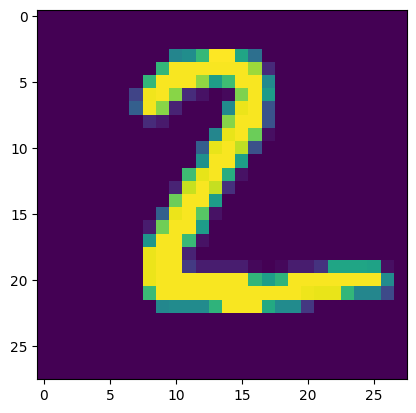

predict: 2
true:    2


In [59]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).view(1, -1).to(device).float()
target = dataset_test.targets[i].tolist()
model1.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model1(data)).squeeze().detach()
print(f"predict: {predict}")
print(f"true:    {target}")

In [60]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [61]:
class ConvDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        # TODO добавить батч норм
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):

        return self.do(self.conv(x))

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = ConvDO(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза
        # TODO еще уменьшить размер фичматрицы
        self.conv2 = ConvDO(hidden_ch, hidden_ch, 3, 1, 1)
        # TODO увеличить число выходных каналов
        self.conv3 = ConvDO(hidden_ch, 1, 3, 1, 1)
        self.linear = nn.Linear(
            14 * 14, # TODO поправить при изменении числа каналов и размера фич матриц
            output_dim,
        )  
        self.activ = nn.ReLU()    

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))
        x = self.linear(x.view(x.size(0), -1))

        return x

In [62]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [63]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [64]:
for epoch in range(n_epochs):
    #train model
    model_conv.train()
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    #test model
    model_conv.eval()
    for i, batch in enumerate(testloader):
        inputs, labels = batch
        loss_test = 0
        with torch.no_grad():
            predict = model_conv(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    print('test loss:', loss_test.item() / i)
    
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3067615032196045
epoch: 0, step: 200, loss: 0.26930296421051025
epoch: 0, step: 400, loss: 0.19015856087207794
test loss: 0.0022478353280525705
epoch: 1, step: 0, loss: 0.23293985426425934
epoch: 1, step: 200, loss: 0.13923588395118713
epoch: 1, step: 400, loss: 0.2649051547050476
test loss: 0.0013911814078108058
epoch: 2, step: 0, loss: 0.15687038004398346
epoch: 2, step: 200, loss: 0.09462924301624298
epoch: 2, step: 400, loss: 0.1831386685371399
test loss: 0.001272949595730026
epoch: 3, step: 0, loss: 0.039685945957899094
epoch: 3, step: 200, loss: 0.09839785099029541
epoch: 3, step: 400, loss: 0.09153498709201813
test loss: 0.0025018614220928834
epoch: 4, step: 0, loss: 0.06401675194501877
epoch: 4, step: 200, loss: 0.16196587681770325
epoch: 4, step: 400, loss: 0.050723180174827576
test loss: 0.0007357893439082356
epoch: 5, step: 0, loss: 0.14731523394584656
epoch: 5, step: 200, loss: 0.07292622327804565
epoch: 5, step: 400, loss: 0.12962335348129272
tes

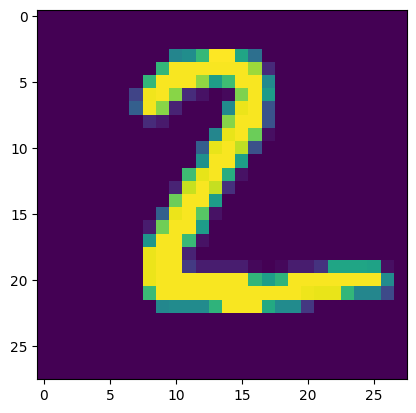

predict: 2
true:    2


In [65]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).unsqueeze(0).to(device).float()
target = dataset_test.targets[i].tolist()
model_conv.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model_conv(data)).squeeze().detach()
print(f"predict: {predict}")
print(f"true:    {target}")

In [66]:
class ConvDO1(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):
                
        return self.do(self.conv(x))

class ConvModel1(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = ConvDO1(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза 14x14
        self.pool = nn.MaxPool2d(kernel_size=2) # TODO еще уменьшить размер фичматрицы 7x7
        self.conv2 = ConvDO1(hidden_ch, hidden_ch, 3, 1, 1)
        self.conv3 = ConvDO1(hidden_ch, 10, 3, 1, 1) # TODO увеличить число выходных каналов
        self.linear1 = nn.Linear(
            10 * 7 * 7, # TODO поправить при изменении числа каналов и размера фич матриц
            200
        )  
        self.linear2 = nn.Linear(200, output_dim)
        self.activ = nn.ReLU()    
        self.bn = nn.BatchNorm2d(hidden_ch) # TODO добавить батч норм

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.pool(x)
        x = self.activ(self.conv2(x))
        x = self.bn(x)
        x = self.activ(self.conv3(x))
        x = self.linear1(x.view(x.size(0), -1))
        x = self.activ(x)
        x = self.linear2(x)
        
        return x

In [ ]:
model_conv1 = ConvModel1(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv1.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(n_epochs):
    #train model
    model_conv1.train()
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv1(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    #test model
    model_conv1.eval()
    for i, batch in enumerate(testloader):
        inputs, labels = batch
        loss_test = 0
        with torch.no_grad():
            predict = model_conv1(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    print('test loss:', loss_test / i)
    
    #save every epoch
    torch.save(model_conv1.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

In [ ]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).unsqueeze(0).to(device).float()
target = dataset_test.targets[i]
model_conv1.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model_conv1(data)).squeeze().detach()
print(f"predict: {predict}")
print(f"true:    {target}")

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
 sample_idx = torch.randint(len(dataset_test), size=(1,)).item()
 img, label = dataset_test[sample_idx]
 data = dataset_test.data[sample_idx].unsqueeze(0).unsqueeze(0).to(device).float()
 predict = torch.argmax(model_conv1(data)).squeeze().detach().item()
 figure.add_subplot(rows, cols, i)
 plt.title(predict)
 plt.axis("off")
 plt.imshow(img.squeeze(), cmap="gray")
plt.show()